In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
from torchsummary import summary

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Class names
CLASS_NAMES = ["CMC_delamination", "Crack", "Debond", "Depth indentation","Edge etching", "Foam", "GFRP_delamination", "Groove", "Hole",
               "Impact damage back", "Impact damage front", "Indentation", "Layer nonuniformity",
               "Layer tear off", "Matrix smearing", "Step indentation", "Void", "Waviness"]
CLASS_DICT = {name: i for i, name in enumerate(CLASS_NAMES)}

# Function to parse XML annotations
def parse_xml(xml_path, img_w, img_h):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bbox = obj.find("bndbox")
        x_min = int(bbox.find("xmin").text) / img_w
        y_min = int(bbox.find("ymin").text) / img_h
        x_max = int(bbox.find("xmax").text) / img_w
        y_max = int(bbox.find("ymax").text) / img_h
        objects.append((name, [x_min, y_min, x_max, y_max]))  # Normalized bbox

    return objects

In [ ]:
# Custom Dataset Class
class DefectDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_paths, self.annotation_paths = [], []

        img_root = os.path.join(root_dir, "images", "train")
        ann_root = os.path.join(root_dir, "annotations", "train")

        for class_name in os.listdir(img_root):
            img_dir = os.path.join(img_root, class_name)
            ann_dir = os.path.join(ann_root, class_name)

            if os.path.isdir(img_dir):
                for img_name in os.listdir(img_dir):
                    if img_name.endswith((".png", ".jpg")):
                        img_path = os.path.join(img_dir, img_name)
                        ann_path = os.path.join(ann_dir, img_name.replace(".png", ".xml").replace(".jpg", ".xml"))
                        if os.path.exists(ann_path):
                            self.image_paths.append(img_path)
                            self.annotation_paths.append(ann_path)

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        orig_h, orig_w = img.shape[:2]
        img = cv2.resize(img, (224, 224))  # Resize to fixed size
        img = T.ToTensor()(img)  # Convert to tensor

        objects = parse_xml(self.annotation_paths[idx], orig_w, orig_h)
        boxes, labels = [], []
        for name, (x_min, y_min, x_max, y_max) in objects:
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(CLASS_DICT[name])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        return img, {"boxes": boxes, "labels": labels}

    def __len__(self):
        return len(self.image_paths)

# Load dataset
root_dir = "/content/drive/MyDrive/Colab Notebooks/CSIR/20 class rcnn"
train_dataset = DefectDataset(root_dir=root_dir)
train_loader = DataLoader(train_dataset, batch_size=18, shuffle=True, collate_fn=lambda batch: tuple(zip(*batch)))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class CustomRCNN(nn.Module):
    def __init__(self, num_classes, roi_size=7):
        super(CustomRCNN, self).__init__()
        self.num_classes = num_classes
        self.roi_size = roi_size

        # Backbone CNN (Feature extractor) with two additional layers
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 1024, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(1024, 1024, 3, padding=1), nn.ReLU(),  # No MaxPool
            nn.Conv2d(1024, 1024, 3, padding=1), nn.ReLU(),  # No MaxPool
            nn.Conv2d(1024, 1024, 3, padding=1), nn.ReLU()   # No MaxPool
        )

        # ROI pooling simulated via adaptive pooling
        self.roi_pool = nn.AdaptiveAvgPool2d((roi_size, roi_size))

        # Fully connected heads with additional layers
        flatten_dim = 1024 * roi_size * roi_size  # Adjusted for new layers
        self.classifier = nn.Sequential(
            nn.Linear(flatten_dim, 2048), nn.ReLU(),
            nn.Linear(2048, 1024), nn.ReLU(),  # Additional layer
            nn.Linear(1024, num_classes)  # Number of defect classes
        )
        self.bbox_regressor = nn.Sequential(
            nn.Linear(flatten_dim, 2048), nn.ReLU(),
            nn.Linear(2048, 1024), nn.ReLU(),  # Additional layer
            nn.Linear(1024, 4)  # Predicts bounding box (x1, y1, x2, y2)
        )

    def forward(self, images, rois=None):
        feat_map = self.backbone(images)  # (B, C, H', W')

        if rois is None:
            B, C, H, W = feat_map.shape
            pooled_feat = self.roi_pool(feat_map)  # (B, C, roi_size, roi_size)
            flattened = pooled_feat.view(B, -1)
        else:
            # Process multiple ROIs for each image in the batch
            roi_features = []
            for batch_idx, roi in enumerate(rois):
                # Each ROI is a list of bounding boxes: [batch_idx, x1, y1, x2, y2]
                for bbox in roi:
                    x1, y1, x2, y2 = map(int, bbox)
                    roi_feat = feat_map[batch_idx:batch_idx+1, :, y1:y2, x1:x2]  # Crop region
                    pooled_feat = self.roi_pool(roi_feat)  # Apply ROI pooling
                    roi_features.append(pooled_feat)

            # Concatenate all ROI features
            roi_features = torch.cat(roi_features, dim=0)
            flattened = roi_features.view(roi_features.size(0), -1)

        # Classification and bounding box regression heads
        class_logits = self.classifier(flattened)
        bbox_preds = torch.sigmoid(self.bbox_regressor(flattened))

        return class_logits, bbox_preds

# Instantiate and move model to device
num_classes = 18  # Assuming you have 18 defect classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomRCNN(num_classes).to(device)

# Print model summary (for single input)
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
         MaxPool2d-9          [-1, 256, 28, 28]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
             ReLU-11          [-1, 512, 28, 28]               0
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       2,359,808
             ReLU-14          [-1, 512,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import time
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

# --- Compute IoU ---
def compute_iou(box1, box2):
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])

    inter = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    union = area1 + area2 - inter + 1e-8
    iou = inter / union
    return iou.mean().item() if len(iou) > 0 else 0.0

# --- Train Model ---
def train_model(model, train_loader, num_epochs=350, lr=0.0005, weight_decay=1e-4):
    model.to(device)
    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

    criterion_cls = FocalLoss()
    criterion_bbox = nn.SmoothL1Loss()

    scaler = amp.GradScaler()

    start_time = time.time()

    # Metric trackers
    epoch_losses = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1_scores = []
    epoch_ious = []

    for epoch in range(num_epochs):
        total_loss = 0
        batch_preds, batch_targets, iou_values = [], [], []
        epoch_start_time = time.time()

        for images, targets in train_loader:
            images = torch.stack([img.to(device, non_blocking=True) for img in images])
            labels = torch.tensor([target["labels"][0] for target in targets], dtype=torch.long, device=device)
            bbox_targets = torch.stack([target["boxes"][0] for target in targets]).to(device)

            optimizer.zero_grad()

            with amp.autocast(device_type='cuda'):  # ✅ correct
                class_logits, bbox_preds = model(images)
                loss_cls = criterion_cls(class_logits, labels)
                loss_bbox = criterion_bbox(bbox_preds, bbox_targets)
                loss = loss_cls + 5 * loss_bbox

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            preds = torch.argmax(class_logits, dim=1).detach().cpu().numpy()
            targets_cpu = labels.detach().cpu().numpy()
            batch_preds.extend(preds)
            batch_targets.extend(targets_cpu)

            iou_values.append(compute_iou(bbox_preds, bbox_targets))

        # --- Compute metrics ---
        precision = precision_score(batch_targets, batch_preds, average='macro', zero_division=1.0)
        recall = recall_score(batch_targets, batch_preds, average='macro', zero_division=1.0)
        f1 = f1_score(batch_targets, batch_preds, average='macro', zero_division=1.0)
        avg_iou = sum(iou_values) / len(iou_values) if iou_values else 0.0

        # --- Store metrics ---
        epoch_losses.append(total_loss)
        epoch_precisions.append(precision)
        epoch_recalls.append(recall)
        epoch_f1_scores.append(f1)
        epoch_ious.append(avg_iou)

        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | "
              f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | IoU: {avg_iou:.4f}")

        scheduler.step()

    end_time = time.time()
    print(f"\n✅ Training complete! Total time: {end_time - start_time:.2f} seconds "
          f"({(end_time - start_time) / 60:.2f} minutes)")

    return model, epoch_losses, epoch_precisions, epoch_recalls, epoch_f1_scores, epoch_ious


# Call
trained_model, epoch_losses, epoch_precisions, epoch_recalls, epoch_f1_scores, epoch_ious = train_model(model, train_loader)


Epoch 1/350 | Loss: 20.5764 | Precision: 0.9074 | Recall: 0.0556 | F1: 0.0270 | IoU: 0.0990
Epoch 2/350 | Loss: 17.4542 | Precision: 0.9602 | Recall: 0.0556 | F1: 0.0246 | IoU: 0.1457
Epoch 3/350 | Loss: 17.4833 | Precision: 0.9602 | Recall: 0.0556 | F1: 0.0246 | IoU: 0.1483
Epoch 4/350 | Loss: 17.3508 | Precision: 0.9602 | Recall: 0.0556 | F1: 0.0246 | IoU: 0.1469
Epoch 5/350 | Loss: 17.4085 | Precision: 0.9602 | Recall: 0.0556 | F1: 0.0246 | IoU: 0.1469
Epoch 6/350 | Loss: 17.2540 | Precision: 0.9602 | Recall: 0.0556 | F1: 0.0246 | IoU: 0.1512
Epoch 7/350 | Loss: 17.1693 | Precision: 0.9602 | Recall: 0.0556 | F1: 0.0246 | IoU: 0.1385
Epoch 8/350 | Loss: 17.0221 | Precision: 0.9602 | Recall: 0.0556 | F1: 0.0246 | IoU: 0.1430
Epoch 9/350 | Loss: 16.6272 | Precision: 0.9602 | Recall: 0.0556 | F1: 0.0246 | IoU: 0.1507
Epoch 10/350 | Loss: 16.3793 | Precision: 0.9181 | Recall: 0.0756 | F1: 0.0413 | IoU: 0.1548
Epoch 11/350 | Loss: 15.9589 | Precision: 0.8780 | Recall: 0.1042 | F1: 0.0529 

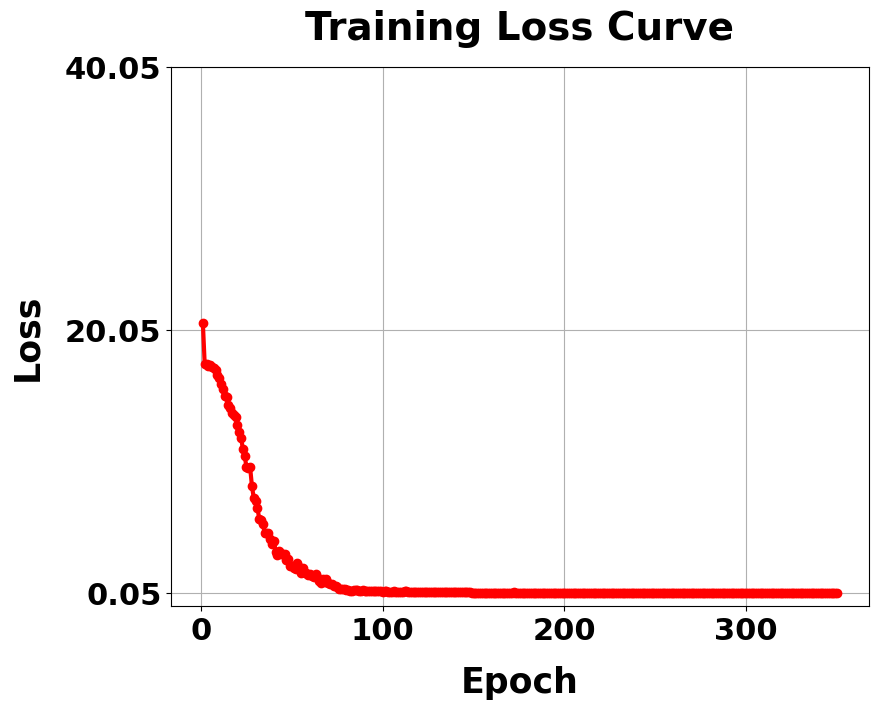

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss_curve(epoch_losses):
    epochs = range(1, len(epoch_losses) + 1)

    plt.figure(figsize=(9, 7))  # Increased figure size for better spacing
    plt.plot(epochs, epoch_losses, marker="o", linestyle="-", color="r", linewidth=3)

    # Labels with padding to prevent cutoff
    plt.xlabel("Epoch", fontsize=25, fontweight='bold', labelpad=15)  # Increased padding
    plt.ylabel("Loss", fontsize=25, fontweight='bold', labelpad=15)   # Increased padding
    plt.title("Training Loss Curve", fontsize=28, fontweight='bold', pad=20)  # Adjusted title padding

    # Set x-axis ticks with gap of 100
    plt.xticks(np.arange(0, len(epoch_losses) + 1, 100), fontsize=22, fontweight='bold')

    # Set y-axis ticks with gap of 20
    plt.yticks(np.arange(min(epoch_losses), max(epoch_losses) + 20, 20), fontsize=22, fontweight='bold')

    plt.grid(True)

    # Save the plot
    plt.savefig('/content/training_loss_curve.svg', format='svg', bbox_inches='tight')
    plt.savefig('/content/training_loss_curve.png', format='png', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage
plot_loss_curve(epoch_losses)


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_precision_recall(model, data_loader):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for images, targets in data_loader:
            images = torch.stack([img.to(device) for img in images])
            labels = torch.tensor([target["labels"][0] for target in targets], dtype=torch.long, device=device)

            class_logits, _ = model(images)
            preds = torch.argmax(class_logits, dim=1).cpu().numpy()
            targets = labels.cpu().numpy()

            all_preds.extend(preds)
            all_targets.extend(targets)

    # Compute per-class metrics
    for class_idx, class_name in enumerate(CLASS_NAMES):
        precision = precision_score(all_targets, all_preds, labels=[class_idx], average='macro', zero_division=1)
        recall = recall_score(all_targets, all_preds, labels=[class_idx], average='macro', zero_division=1)
        f1 = f1_score(all_targets, all_preds, labels=[class_idx], average='macro', zero_division=1)
        print(f"Class: {class_name}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Compute overall metrics
    overall_precision = precision_score(all_targets, all_preds, average='macro', zero_division=1)
    overall_recall = recall_score(all_targets, all_preds, average='macro', zero_division=1)
    overall_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=1)

    print(f"\nOverall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")

# Run the evaluation
compute_precision_recall(model, train_loader)


Class: CMC_delamination, Precision: 1.0000, Recall: 0.9444, F1 Score: 0.9714
Class: Crack, Precision: 0.9615, Recall: 1.0000, F1 Score: 0.9804
Class: Debond, Precision: 0.9927, Recall: 0.9927, F1 Score: 0.9927
Class: Depth indentation, Precision: 0.7500, Recall: 0.7500, F1 Score: 0.7500
Class: Edge etching, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Foam, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: GFRP_delamination, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Groove, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Hole, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Impact damage back, Precision: 0.9333, Recall: 0.9333, F1 Score: 0.9333
Class: Impact damage front, Precision: 0.9500, Recall: 0.9500, F1 Score: 0.9500
Class: Indentation, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class: Layer nonuniformity, Precision: 0.9630, Recall: 1.0000, F1 Score: 0.9811
Class: Layer tear off, Precision: 1.0000, Recall: 1.0

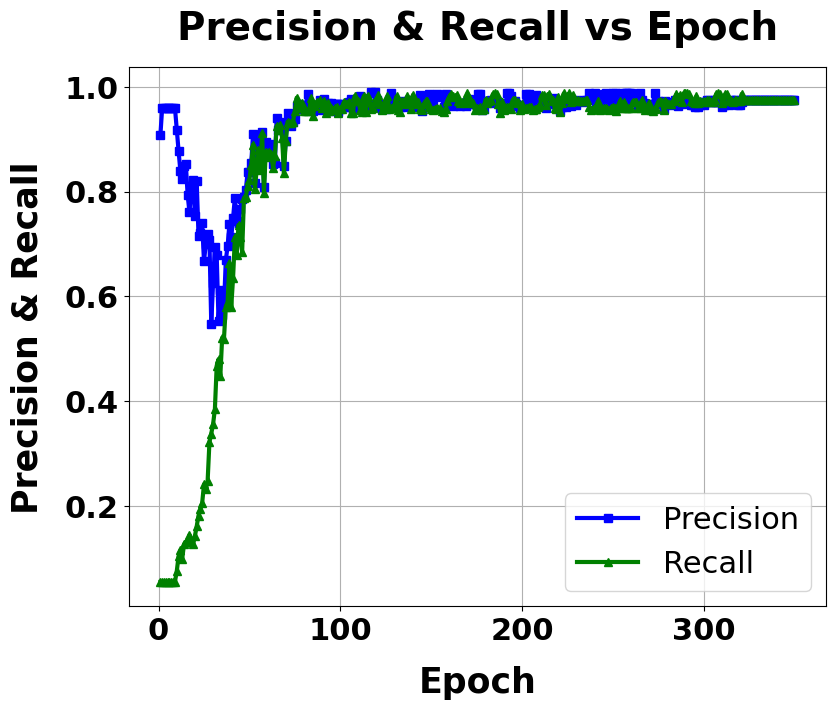

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics_curve(epoch_precisions, epoch_recalls):
    epochs = range(1, len(epoch_precisions) + 1)

    plt.figure(figsize=(9, 7))  # Increased figure size for better spacing
    plt.plot(epochs, epoch_precisions, marker="s", linestyle="-", color="b", linewidth=3, label="Precision")
    plt.plot(epochs, epoch_recalls, marker="^", linestyle="-", color="g", linewidth=3, label="Recall")

    # Labels with padding to prevent cutoff
    plt.xlabel("Epoch", fontsize=25, fontweight='bold', labelpad=15)
    plt.ylabel("Precision & Recall", fontsize=25, fontweight='bold', labelpad=15)
    plt.title("Precision & Recall vs Epoch", fontsize=28, fontweight='bold', pad=20)

    # Set x-axis ticks (gap of 100 epochs)
    plt.xticks(np.arange(0, len(epoch_precisions) + 1, 100), fontsize=22, fontweight='bold')

    # Keep default y-axis values but with large font
    plt.yticks(fontsize=22, fontweight='bold')

    plt.legend(fontsize=22, loc='best')  # Adjust legend size & position
    plt.grid(True)

    # Save the plot with tight bounding box to prevent text cutoff
    plt.savefig('/content/training_metrics_curve.svg', format='svg', bbox_inches='tight')
    plt.savefig('/content/training_metrics_curve.png', format='png', bbox_inches='tight')

    # Show the plot
    plt.show()

# Example usage
plot_metrics_curve(epoch_precisions, epoch_recalls)


In [ ]:
#IoU calculation function
def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    box1, box2: [x_min, y_min, x_max, y_max]
    """

    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the intersection area
    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Compute the union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    # Avoid division by zero
    iou = intersection / (union + 1e-8)
    return iou
#iou evalution
def evaluate_iou(model, dataloader):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            gt_boxes = [target["boxes"][0].cpu().numpy() for target in targets]

            pred_boxes = []
            for img in images:
                _, bbox_preds = model(img.unsqueeze(0))  # Get predictions
                pred_boxes.append(bbox_preds.cpu().squeeze().numpy())

            for gt_box, pred_box in zip(gt_boxes, pred_boxes):
                iou = compute_iou(gt_box, pred_box)
                iou_scores.append(iou)

    mean_iou = np.mean(iou_scores)
    print(f"Mean IoU: {mean_iou:.4f}")
    return iou_scores

# Run IoU evaluation
iou_scores = evaluate_iou(model, train_loader)


Mean IoU: 0.9757


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix

def debug_validation_data(model, dataset_root, device):
    print("Generating visual predictions with bounding boxes...\n")

    save_root = "/content/drive/MyDrive/Validation_Results"
    bbox_dir = os.path.join(save_root, "Bounding_Boxes")
    confmat_dir = os.path.join(save_root, "Confusion_Matrix")
    os.makedirs(bbox_dir, exist_ok=True)
    os.makedirs(confmat_dir, exist_ok=True)

    val_img_root = os.path.join(dataset_root, "images", "val")
    val_ann_root = os.path.join(dataset_root, "annotations", "val")

    y_true = []
    y_pred = []
    processing_times = []
    csv_records = []

    for class_name in os.listdir(val_img_root):
        class_idx = CLASS_DICT.get(class_name)
        if class_idx is None:
            continue

        img_dir = os.path.join(val_img_root, class_name)
        ann_dir = os.path.join(val_ann_root, class_name)

        if not os.path.isdir(img_dir):
            continue

        for img_name in os.listdir(img_dir):
            if not img_name.endswith((".png", ".jpg")):
                continue

            img_path = os.path.join(img_dir, img_name)
            ann_path = os.path.join(ann_dir, img_name.replace(".png", ".xml").replace(".jpg", ".xml"))

            if not os.path.exists(ann_path):
                continue

            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_h, orig_w = img.shape[:2]
            objects = parse_xml(ann_path, orig_w, orig_h)

            if not objects:
                continue

            true_label = objects[0][0]
            true_bbox = objects[0][1]

            input_img = T.ToTensor()(cv2.resize(img, (224, 224))).unsqueeze(0).to(device)

            start_time = time.time()
            with torch.no_grad():
                class_logits, bbox_preds = model(input_img)
            end_time = time.time()

            processing_time = end_time - start_time
            processing_times.append(processing_time)

            pred_label_idx = torch.argmax(class_logits, dim=1).item()
            pred_label = [k for k, v in CLASS_DICT.items() if v == pred_label_idx][0]
            pred_bbox = bbox_preds.squeeze().cpu().numpy()

            pred_bbox_pix = [int(pred_bbox[0] * orig_w),
                             int(pred_bbox[1] * orig_h),
                             int(pred_bbox[2] * orig_w),
                             int(pred_bbox[3] * orig_h)]

            pred_bbox_norm = [
                pred_bbox_pix[0] / orig_w,
                pred_bbox_pix[1] / orig_h,
                pred_bbox_pix[2] / orig_w,
                pred_bbox_pix[3] / orig_h,
            ]

            iou = compute_iou(torch.tensor([true_bbox]), torch.tensor([pred_bbox_norm]))

            y_true.append(true_label)
            y_pred.append(pred_label)

            img_with_boxes = draw_bounding_boxes(img.copy(), true_bbox, pred_bbox_pix, true_label, pred_label)

            # SAVE image
            save_path = os.path.join(bbox_dir, f"{img_name.split('.')[0]}_bbox.jpg")
            cv2.imwrite(save_path, cv2.cvtColor(img_with_boxes, cv2.COLOR_RGB2BGR))

            # PRINT image
            plt.figure(figsize=(8,6))
            plt.imshow(img_with_boxes)
            plt.title(f"True: {true_label} | Pred: {pred_label} | IoU: {iou:.2f}")
            plt.axis('off')
            plt.show()

            # Record for CSV
            csv_records.append({
                "Image Name": img_name,
                "True Label": true_label,
                "Predicted Label": pred_label,
                "IoU": round(iou, 4),
                "Processing Time (s)": round(processing_time, 4)
            })

    # Confusion Matrix
    unique_labels = sorted(set(y_true + y_pred))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Save and display confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    confmat_path = os.path.join(confmat_dir, "confusion_matrix.png")
    plt.savefig(confmat_path)
    plt.show()  # Display confusion matrix
    plt.close()

    # Save CSV file
    csv_save_path = os.path.join(save_root, "results_summary.csv")
    df = pd.DataFrame(csv_records)

    avg_time = sum(processing_times) / len(processing_times) if processing_times else 0
    total_time = sum(processing_times)

    extra_df = pd.DataFrame([
        {"Image Name": "TOTAL", "True Label": "-", "Predicted Label": "-", "IoU": "-", "Processing Time (s)": round(total_time, 4)},
        {"Image Name": "AVERAGE", "True Label": "-", "Predicted Label": "-", "IoU": "-", "Processing Time (s)": round(avg_time, 4)}
    ])

    final_df = pd.concat([df, extra_df], ignore_index=True)
    final_df.to_csv(csv_save_path, index=False)

    print(f"\nAvg. processing time: {avg_time:.4f} sec")
    print(f"Total processing time: {total_time:.4f} sec")
    print(f"Total processed images: {len(processing_times)}")
    print(f"Saved bounding boxes to: {bbox_dir}")
    print(f"Saved confusion matrix to: {confmat_path}")
    print(f"Saved CSV results summary to: {csv_save_path}")

    return
# Usage
dataset_root = "/content/drive/MyDrive/Colab Notebooks/CSIR/20 class rcnn"
sample_data = debug_validation_data(model, dataset_root, device)